## Loading Data:

In [1]:
# Libraries:
import os
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch Packages:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data        import DataLoader, TensorDataset

# Sci-Kit Learn Packages:
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.preprocessing   import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error

# Loading Data:
def load_data (data_id = "31698", coor_type = "XYZ"):
    if data_id not in ["31698", "31722", "36605", "40309"]:
        raise ValueError("Invalid `data_id` value.")
    if coor_type not in ["XYZ", "RTN"]:
        raise ValueError("Invalid `coor_type` value.")
    full_dir = os.path.join("./Dataset", data_id, coor_type, "P1.csv")
    return pd.read_csv(full_dir)

# Visualisation:
df = load_data(coor_type = "RTN")

# Remove `Unnamed: 0` Column:
df.drop("Unnamed: 0", axis = "columns", inplace = True)

## Display Errors:

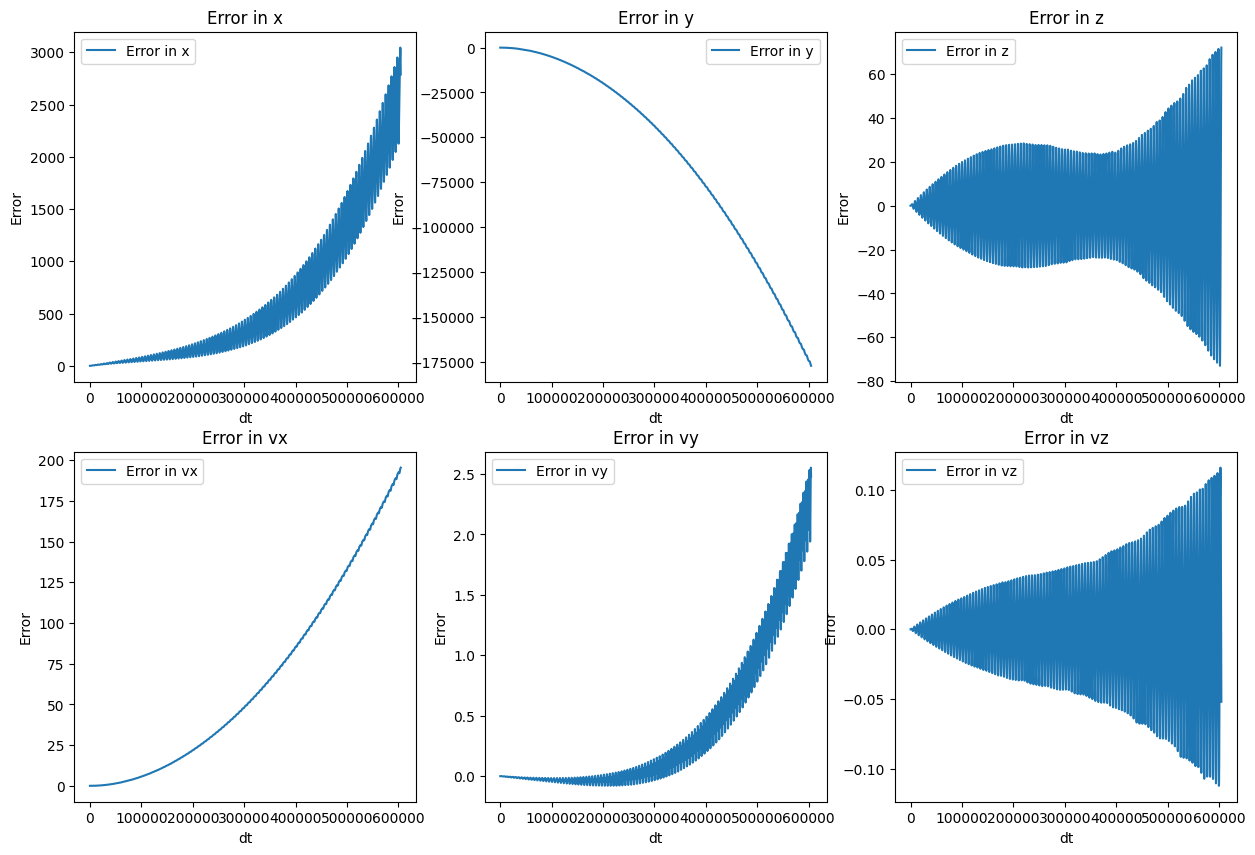

In [2]:
def plot_errors (df = df, target_time = 0.0):
    if target_time not in df["Time"].unique():
        raise ValueError("Invalid `target_time` value.")
    # Filter by `Time` = target_time.
    df_filter = df[df["Time"] == target_time]
    # Create subplots.
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    # Plot differences:
    for idx, coord in enumerate(["x", "y", "z", "vx", "vy", "vz"]):
        true_val = "True_" + coord
        pred_val = "Approx_" + coord
        ax = axs[idx // 3, idx % 3]
        ax.plot(
            df_filter["Delta_t"], df_filter[pred_val] - df_filter[true_val],
            label = "Error in " + coord
        )
        ax.set_xlabel("dt")
        ax.set_ylabel("Error")
        ax.set_title("Error in " + coord)
        ax.legend()
    plt.show()

plot_errors()

## Pre-Processing

In [3]:
# Replace `True` and `Approx` Columns by their Error:
for coord in ["x", "y", "z"]:
    # Create Error Columns:
    # 1: For Position
    true_pos = "True_" + coord
    pred_pos = "Approx_" + coord
    error_pos = "Error_" + coord
    df[error_pos] = df[pred_pos] - df[true_pos]
    # 2: For Velocity
    true_vel = "True_v" + coord
    pred_vel = "Approx_v" + coord
    error_vel = "Error_v" + coord
    df[error_vel] = df[pred_pos] - df[true_pos]
    # Drop `True` and `Approx` Columns:
    # 1: For Position
    df.drop(true_pos, axis = "columns", inplace = True)
    df.drop(pred_pos, axis = "columns", inplace = True)
    # 2: For Velocity
    df.drop(true_vel, axis = "columns", inplace = True)
    df.drop(pred_vel, axis = "columns", inplace = True)

df.head(5)

,Time,Delta_t,c1_x,c1_y,c1_z,c1_vx,c1_vy,c1_vz,c1_t,c2_x,...,c5_vx,c5_vy,c5_vz,c5_t,Error_x,Error_vx,Error_y,Error_vy,Error_z,Error_vz
0,0.0,0.0,-6.409894,-67.908324,2.485850,0.076227,0.002874,-0.001670,-10725.092378,-60.424817,...,275.296167,5.073458,-0.138456,-672102.787275,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,300.0,-11.912883,-178.463405,2.590256,0.198689,0.007096,0.004073,-17801.666518,-76.037030,...,269.677579,5.161352,-0.022072,-666020.259607,0.027023,0.027023,0.016470,0.016470,-0.001112,-0.001112
2,0.0,600.0,-10.764104,-108.981466,-3.250745,0.120754,0.006927,0.001847,-13657.466810,-82.408149,...,281.144332,5.681144,-0.251754,-679351.799402,0.116288,0.116288,0.013723,0.013723,0.006213,0.006213
3,0.0,900.0,0.000082,0.000121,-0.000017,-0.000008,-0.000012,0.000002,-19.441757,-77.274930,...,286.834087,5.537690,0.183825,-686536.541182,0.241138,0.241138,-0.072020,-0.072020,0.036418,0.036418
4,0.0,1200.0,-19.798722,-618.302093,6.792656,0.684463,0.007596,-0.006816,-33422.058565,-66.446184,...,273.861609,5.451881,0.061794,-671472.663312,0.344025,0.344025,-0.252139,-0.252139,0.099122,0.099122


## Selecting Label and Generating Training/Testing Data

In [4]:
def filter_data_by_label (df, target_label = "x"):
    if target_label not in ["x", "y", "z", "vx", "vy", "vz"]:
        raise ValueError("Invalid `target_label` value.")
    # Select Columns:
    target_columns = [
        "Time",
        "Delta_t", 
        "c1_" + target_label, "c1_t",
        "c2_" + target_label, "c2_t",
        "c3_" + target_label, "c3_t",
        "c4_" + target_label, "c4_t",
        "c5_" + target_label, "c5_t"
    ]
    return df[target_columns], df["Error_" + target_label]
    
def group_train_test_split (X, y, group_factor = "Time"):
    groups = X[group_factor]
    gss = GroupShuffleSplit(
        n_splits = 1, test_size = 0.2, random_state = 42
    )
    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
        X_train = X.iloc[train_index]; X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]; y_test = y.iloc[test_index]
    return X_train, y_train, X_test, y_test

## Polynomial Feature Scaling and Normalisation:

In [94]:
def pre_process (X_train, X_test, poly = True, factor = 2):
    if poly and factor is not None:
        poly = PolynomialFeatures(factor)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    return X_train_norm, X_test_norm, poly, scaler

## Single Object Selection:

In [6]:
def filter_object (X_test, y_test, target_time = None):
    target_time = None
    if target_time is None:
        target_time = X_test["Time"].unique()[0]
    elif (target_time is not None) and (target_time not in X_test["Time"].unique()):
        raise ValueError("Invalid `target_time` value.")
    # Filter Dataset:
    target_idxs = X_test["Time"] == target_time
    X_test_sub = X_test[target_idxs]
    y_test_sub = y_test[target_idxs]
    return X_test_sub, y_test_sub

## Display Results:

In [7]:
def display_predictions (X_test, y_test, predictions, scatter = True):
    if scatter:
        plt.scatter(X_test["Delta_t"], y_test, label = "Real Error")
        plt.scatter(X_test["Delta_t"], predictions, label = "Predicted Error")
    else:
        plt.plot(X_test["Delta_t"], y_test, label = "Real Error")
        plt.plot(X_test["Delta_t"], predictions, label = "Predicted Error")
    plt.xlabel("Time-Step")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.show()

## Multi-Layer Perceptron:

In [ ]:
def prepare_data_neural_network (df, target_label, single_obj = True):
    # Select Target Variable:
    X, y = filter_data_by_label (df, target_label = "x")
    # Split into Training and Testing:
    X_train, y_train, X_test, y_test = group_train_test_split (X, y)
    # Pre-Processing:
    X_train_norm, X_test_norm, poly, scaler = pre_process (
        X_train.drop("Time", axis = "columns"),
        X_test.drop("Time", axis = "columns")
    )
    # Convert to Tensor:
    X_train_norm = torch.tensor(X_train_norm, dtype = torch.float32)
    X_test_norm = torch.tensor(X_test_norm, dtype = torch.float32)
    y_train = torch.tensor(y_train.values, dtype = torch.float32).reshape(-1, 1)
    y_test = torch.tensor(y_test.values, dtype = torch.float32).reshape(-1, 1)
    # Generate Single Object:
    if single_obj:
        return X_train_norm, X_test_norm, y_train, y_test
    else:
        # Select One Single Object:
        target_time = X_test["Time"].unique()[0]
        target_idxs = X_test["Time"] == target_time
        X_obj = X_test[target_idxs]
        y_obj = y_test[target_idxs]
        
        X_obj_norm = scaler.transform(poly.transform(X_obj.drop("Time", axis = "columns")))


In [103]:
# Select Target Variable:
X, y = filter_data_by_label (df, target_label = "x")

# Split into Training and Testing:
X_train, y_train, X_test, y_test = group_train_test_split (X, y)

# Select One Single Object:
target_time = X_test["Time"].unique()[0]
target_idxs = X_test["Time"] == target_time

X_obj = X_test[target_idxs]
y_obj = y_test[target_idxs]

# Pre-Processing:
X_train_norm, X_test_norm, poly, scaler = pre_process (
    X_train.drop("Time", axis = "columns"),
    X_test.drop("Time", axis = "columns")
)

X_obj_norm = scaler.transform(poly.transform(X_obj.drop("Time", axis = "columns")))

# Convert to Tensor:
X_train_norm = torch.tensor(X_train_norm, dtype = torch.float32)
X_test_norm = torch.tensor(X_test_norm, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype = torch.float32).reshape(-1, 1)
X_obj_norm = torch.tensor(X_obj_norm, dtype = torch.float32)

In [63]:
# Select Target Variable:
X, y = filter_data_by_label (df, target_label = "x")

# Split into Training and Testing Data:
X_train, y_train, X_test, y_test = group_train_test_split (X, y)

# Pre-Process the Data:
X_train_norm, X_test_norm = pre_process (X_train, X_test)

# Convert it to Tensors:
X_train_norm = torch.tensor(X_train_norm, dtype = torch.float32)
X_test_norm = torch.tensor(X_test_norm, dtype = torch.float32)
y_train = torch.tensor(y_train.values, dtype = torch.float32).reshape(-1, 1)
y_test = torch.tensor(y_test.values, dtype = torch.float32).reshape(-1, 1)

In [68]:
# Create Network:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(in_features = X_train_norm.shape[1], out_features = 128)
        self.layer2 = nn.Linear(in_features = 128, out_features = 64)
        self.layer3 = nn.Linear(in_features =  64, out_features = 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)


# Create DataLoader:
train_dataset = TensorDataset(X_train_norm, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

# Initialize the Model, Loss Function, and Optimizer:
model = RegressionNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Training Loop:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        # Reset Gradients:
        optimizer.zero_grad()
        
        # Forward Pass:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward Pass and Optimisation:
        loss.backward()
        optimizer.step()
        
        # Update:
        running_loss += loss.item()
    
    # Results:
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1} / {num_epochs}], \t Loss: {running_loss / len(train_loader) : 6.4f}")

# Results:
predictions = model.forward(X_test)
with torch.no_grad():
    rmse = math.sqrt(mean_squared_error(predictions, y_test))
    print(f"MLP RMSE: {rmse : 5.2f}")
    display_predictions (X_test, y_test, predictions, scatter = True)

Epoch [10 / 100], 	 Loss:  32303.0352
Epoch [20 / 100], 	 Loss:  26328.1813
Epoch [30 / 100], 	 Loss:  23967.9716
Epoch [40 / 100], 	 Loss:  23338.3391
Epoch [50 / 100], 	 Loss:  22954.9195
Epoch [60 / 100], 	 Loss:  22717.3577
Epoch [70 / 100], 	 Loss:  22722.9678
Epoch [80 / 100], 	 Loss:  22536.9732
Epoch [90 / 100], 	 Loss:  22447.5067
Epoch [100 / 100], 	 Loss:  22481.0894


TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [8]:
class CustomMLP (torch.nn.Module):
    def __init__ (self):
        super(CustomMLP, self).__init__()
        self.layer1 = torch.nn.Linear(784, 512)
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, 10)

    def forward (self, input):
        output = torch.flatten(input, start_dim = 1)
        output = torch.relu(self.layer1(output))
        output = torch.relu(self.layer2(output))
        output = self.layer3(output)
        return output